# Notebook Huấn luyện Mô hình Phân loại (Frame-by-Frame)

## 1. Cài đặt & Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, make_scorer
import xgboost as xgb

# --- Hằng số Toàn cục ---
FEATURES_DIM = 132  # 33 điểm * 4 thông số (x, y, z, visibility)
NUM_LABELS = 3      # [label_back, label_high, label_shrug]

## 2. Các Hàm Tiện ích (Helpers)

### Hàm load_and_preprocess_data

* **Mục đích:** Tải file CSV và xử lý dữ liệu theo từng frame (frame-by-frame) để chuẩn bị cho các mô hình phân loại.
* **Input:** `csv_path` (đường dẫn đến file summary_...csv).
* **Output:** `X` (dữ liệu 2D, shape: [số\_frame, FEATURES\_DIM]) và `y` (nhãn 2D, shape: [số\_frame, NUM\_LABELS]).
* **Logic:**
    1.  **Đọc file CSV** bằng Pandas.
    2.  **Trích xuất features:** Lấy các cột `lm_*` (landmark features) làm input X.
    3.  **Trích xuất labels:** Lấy các cột nhãn (label_back, label_high, label_shrug) làm output y.

In [6]:
def load_and_preprocess_data(csv_path):
    """
    Đọc CSV và trả về dữ liệu dạng Frame-by-Frame (2D).
    Thích hợp cho mạng Dense/MLP.
    """
    print(f"⚡ Đang đọc dữ liệu frame-by-frame từ: {csv_path}...")
    df = pd.read_csv(csv_path)
    
    # Validate cột
    required_labels = ['label_back', 'label_high', 'label_shrug']
    feature_cols = [c for c in df.columns if c.startswith('lm_')]
    
    if not feature_cols:
        raise ValueError("Không tìm thấy cột features (lm_...)")

    # Lấy dữ liệu thô, KHÔNG gom nhóm, KHÔNG padding
    X = df[feature_cols].to_numpy(dtype='float32')
    y = df[required_labels].to_numpy(dtype='float32')

    print(f"--- Hoàn tất (Frame-based) ---\n")
    print(f"Input Shape (X): {X.shape} -> (Tổng số frames, 132)") # Mong đợi: (N, 132)
    print(f"Label Shape (y): {y.shape}")
    
    return X, y

### Hàm tính Class Weights

* **Mục đích:** Tính toán trọng số cho mỗi nhãn để xử lý vấn đề dữ liệu mất cân bằng (imbalanced).
* **Tại sao:** Trong dữ liệu của chúng ta, các lỗi (ví dụ: 'label_shrug') rất hiếm so với các frame 'Correct'. 
* **Logic:** Hàm này tính trọng số cho class 0 và class 1 của mỗi nhãn dựa trên tỷ lệ xuất hiện.

In [ ]:
def compute_class_weights(y_train, label_names):
    """
    Tính class weights cho từng nhãn trong multi-label classification.
    
    Parameters:
    -----------
    y_train : np.array, shape (n_samples, n_labels)
        Ma trận nhãn training
    label_names : list
        Danh sách tên các nhãn
    
    Returns:
    --------
    class_weight_dicts : list of dict
        Danh sách các dictionary chứa class weights cho mỗi nhãn
    """
    class_weight_dicts = []
    
    print("=== Tính toán Class Weights ===")
    for i, label_name in enumerate(label_names):
        n_samples = len(y_train)
        n_positive = np.sum(y_train[:, i])
        n_negative = n_samples - n_positive
        
        # Tính weight: nặng hơn cho class thiểu số
        weight_for_0 = n_samples / (2.0 * n_negative) if n_negative > 0 else 1.0
        weight_for_1 = n_samples / (2.0 * n_positive) if n_positive > 0 else 1.0
        
        class_weight = {0: weight_for_0, 1: weight_for_1}
        class_weight_dicts.append(class_weight)
        
        print(f"{label_name}:")
        print(f"  Positive: {n_positive} ({n_positive/n_samples*100:.2f}%)")
        print(f"  Negative: {n_negative} ({n_negative/n_samples*100:.2f}%)")
        print(f"  Weights: {class_weight}")
    
    return class_weight_dicts

## 3. Tải Dữ liệu & Tính Trọng số Loss

### 3.1. Tải dữ liệu thô để tính trọng số

Trước tiên, chúng ta tải file CSV vào một DataFrame `df` tổng thể. Mục đích là để phân tích phân phối nhãn và tính toán trọng số (pos_weight) cho hàm loss.

In [8]:
# Định nghĩa các biến cần thiết
SUMMARY_CSV_PATH = 'output/summary_lateral_raise.csv'
label_cols = ['label_back', 'label_high', 'label_shrug']

print(f"Đang tải dữ liệu từ {SUMMARY_CSV_PATH} để tính trọng số...")
try:
    # Đọc file CSV
    df = pd.read_csv(SUMMARY_CSV_PATH)
    print("Tải dữ liệu thành công.")
    print(f"Tìm thấy tổng cộng {len(df)} frame dữ liệu.")
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file tại '{SUMMARY_CSV_PATH}'.")
    print("Vui lòng đảm bảo bạn đã chạy notebook xử lý video trước đó.")
except Exception as e:
    print(f"LỖI: Không thể tải file CSV. {e}")

Đang tải dữ liệu từ output/summary_lateral_raise.csv để tính trọng số...
Tải dữ liệu thành công.
Tìm thấy tổng cộng 5941 frame dữ liệu.


### 3.2. Tính toán Trọng số (pos_weight)

Dựa trên `df` vừa tải, chúng ta tính tỷ lệ mất cân bằng giữa các lớp. Điều này giúp hàm loss "phạt" mô hình nặng hơn khi nó dự đoán sai các lỗi hiếm gặp, cải thiện khả năng phát hiện lỗi.

In [ ]:
# Định nghĩa các biến cần thiết
SUMMARY_CSV_PATH = 'output/summary_lateral_raise.csv'
label_cols = ['label_back', 'label_high', 'label_shrug']

print(f"Đang tải dữ liệu từ {SUMMARY_CSV_PATH}...")
try:
    # Đọc file CSV
    df = pd.read_csv(SUMMARY_CSV_PATH)
    print("Tải dữ liệu thành công.")
    print(f"Tìm thấy tổng cộng {len(df)} frame dữ liệu.")
    
    # Hiển thị thông tin cơ bản
    print(f"\nPhân phối nhãn:")
    for label in label_cols:
        count = df[label].sum()
        percentage = (count / len(df)) * 100
        print(f"  {label}: {count} ({percentage:.2f}%)")
        
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file tại '{SUMMARY_CSV_PATH}'.")
    print("Vui lòng đảm bảo bạn đã chạy notebook xử lý video trước đó.")
except Exception as e:
    print(f"LỖI: Không thể tải file CSV. {e}")

--- Tính toán Trọng số (pos_weight) ---
Tổng số frame (mẫu): 5941
Thứ tự các lớp (Labels): ['label_back', 'label_high', 'label_shrug']
Số mẫu dương (Positive Counts): [2621  586   51]
==> Trọng số (pos_weight) đã tính toán: [  1.266692   9.138226 115.4902  ]

--- HOÀN TẤT ---
Biến 'weighted_bce_loss' đã sẵn sàng để sử dụng trong model.compile().


## 4. Tải & Tiền xử lý Dữ liệu cho Model

In [15]:
# Gọi hàm (Đảm bảo đường dẫn đúng với file bạn vừa tạo ở bước trước)
SUMMARY_CSV_PATH = 'output/summary_lateral_raise.csv' # Sửa lại nếu tên file khác

try:
    X_train, y_train = load_and_preprocess_data(SUMMARY_CSV_PATH)
except Exception as e:
    print(f"Lỗi: {e}")

⚡ Đang đọc dữ liệu frame-by-frame từ: output/summary_lateral_raise.csv...
--- Hoàn tất (Frame-based) ---

Input Shape (X): (5941, 132) -> (Tổng số frames, 132)
Label Shape (y): (5941, 3)


## 4.1. Tách Dữ liệu (Train/Validation Split)

Bây giờ, chúng ta sẽ tách bộ dữ liệu `(X_train, y_train)` thành hai phần:
* **Tập Train (Huấn luyện):** Dùng để huấn luyện (fit) mô hình (ví dụ: 80% dữ liệu).
* **Tập Validation (Đánh giá):** Dùng để đánh giá hiệu suất mô hình trên dữ liệu "lạ" (ví dụ: 20% dữ liệu).

Chúng ta sẽ dùng `stratify` để đảm bảo tỷ lệ mẫu "Đúng form" và "Có lỗi" được giữ nguyên ở cả hai tập.

In [16]:
from sklearn.model_selection import train_test_split

# (Kiểm tra xem X_train/y_train đã tồn tại từ Phần 4 chưa)
if 'X_train' not in locals() or 'y_train' not in locals():
    print("LỖI: Vui lòng chạy Phần 4 (Tải & Tiền xử lý Dữ liệu) trước.")
else:
    # --- Tạo cột Stratify ---
    # Vì đây là multi-label, chúng ta không thể stratify trực tiếp trên mảng [N, 3].
    # Một chiến lược tốt là stratify dựa trên "Correct" [0,0,0,0] vs "Có lỗi" (bất kỳ).
    # Bằng cách này, tỷ lệ mẫu "Correct" sẽ như nhau ở cả 2 tập.
    
    # y_stratify sẽ là [0, 1, 0, 0, 1, ...] (0 = 'Correct', 1 = 'Có lỗi')
    y_stratify = np.any(y_train, axis=1).astype(int) 

    # --- Tách Dữ liệu ---
    # Đổi tên biến gốc để tránh nhầm lẫn
    X_train_full, y_train_full = X_train, y_train 
    
    # Tách thành 2 bộ mới
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train_full, 
        y_train_full, 
        test_size=0.2,          # Tỷ lệ 20% cho tập validation
        random_state=42,        # Đảm bảo kết quả lặp lại được
        stratify=y_stratify     # <--- Rất quan trọng cho dữ liệu mất cân bằng
    )
    
    print("--- TÁCH DỮ LIỆU HOÀN TẤT ---")
    print(f"Tổng số mẫu ban đầu : {len(X_train_full)}")
    print(f"Số mẫu Train (X_train_split): {X_train_split.shape}")
    print(f"Số mẫu Val (X_val_split)  : {X_val_split.shape}")
    
    # In ra tỷ lệ phân chia lỗi để kiểm tra
    print("\nKiểm tra phân bổ (Tỷ lệ mẫu 'Có lỗi'):")
    print(f"  Tập gốc:   {np.mean(y_stratify):.3f}")
    print(f"  Tập train: {np.mean(np.any(y_train_split, axis=1)):.3f}")
    print(f"  Tập val:   {np.mean(np.any(y_val_split, axis=1)):.3f}")

--- TÁCH DỮ LIỆU HOÀN TẤT ---
Tổng số mẫu ban đầu : 5941
Số mẫu Train (X_train_split): (4752, 132)
Số mẫu Val (X_val_split)  : (1189, 132)

Kiểm tra phân bổ (Tỷ lệ mẫu 'Có lỗi'):
  Tập gốc:   0.513
  Tập train: 0.513
  Tập val:   0.513


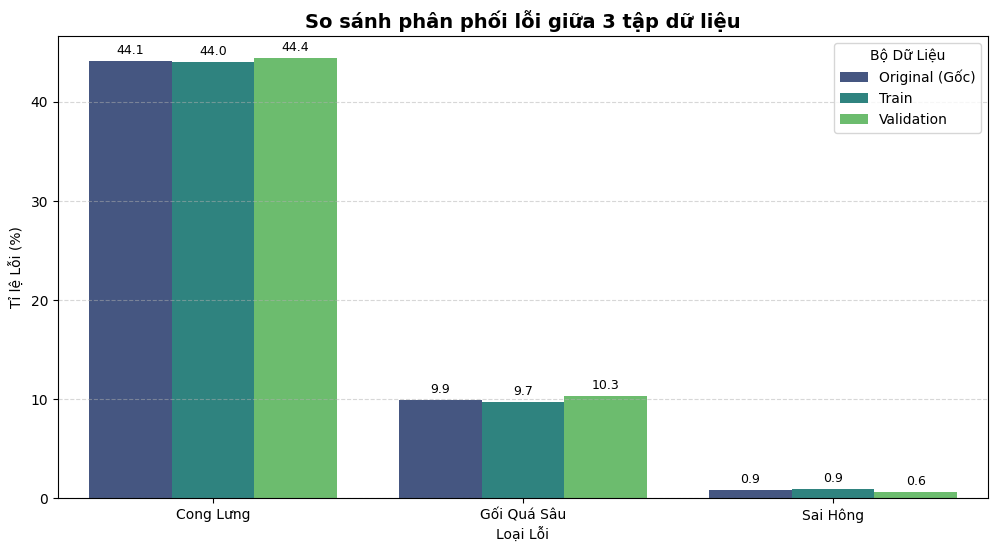

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. CHUẨN BỊ DỮ LIỆU (Thay bằng biến thật của em) ---
# Ví dụ: y_full (Gốc), y_train (Sau chia), y_val (Sau chia)
# Giả sử tên các lỗi của em là:
label_names = ['Cong Lưng', 'Gối Quá Sâu', 'Sai Hông']

# Hàm nhỏ để tính % lỗi cho nhanh
def get_error_rates(y_data, dataset_name):
    # Tính trung bình từng cột -> nhân 100 ra %
    rates = np.mean(y_data, axis=0) * 100
    df = pd.DataFrame({'Loại Lỗi': label_names, 'Tỉ lệ Lỗi (%)': rates})
    df['Dataset'] = dataset_name # Đánh dấu tên tập
    return df

# Tạo 3 bảng số liệu
df_orig = get_error_rates(y_train_full, 'Original (Gốc)')
df_train = get_error_rates(y_train_split, 'Train')
df_val  = get_error_rates(y_val_split, 'Validation')

# Gộp 3 bảng lại thành 1 bảng dài (Long-form)
df_final = pd.concat([df_orig, df_train, df_val], axis=0)

# --- 2. VẼ BIỂU ĐỒ (Seaborn lo hết) ---
plt.figure(figsize=(12, 6))

# hue='Dataset' -> Chính là cái tạo ra 3 màu so sánh
ax = sns.barplot(
    data=df_final, 
    x='Loại Lỗi', 
    y='Tỉ lệ Lỗi (%)', 
    hue='Dataset', 
    palette='viridis' # Chọn màu cho ngầu
)

# --- 3. TRANG TRÍ ---
plt.title('So sánh phân phối lỗi giữa 3 tập dữ liệu', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Bộ Dữ Liệu')

# (Optional) Hiện số lên đầu cột - Code hơi dài tí nhưng nhìn rất pro
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3, fontsize=9)

plt.show()

## 5. Tạo và Huấn luyện 3 Mô hình Phân loại với GridSearchCV

Chúng ta sẽ tạo và tối ưu hóa 3 mô hình:
* **Logistic Regression:** Mô hình tuyến tính đơn giản nhưng hiệu quả
* **Random Forest:** Mô hình ensemble dựa trên decision trees
* **XGBoost:** Mô hình gradient boosting mạnh mẽ

Mỗi mô hình sẽ được tối ưu hóa bằng GridSearchCV để tìm ra siêu tham số tốt nhất.

In [ ]:
import os
from sklearn.metrics import classification_report
import time

# Tạo thư mục lưu models
os.makedirs('model_checkpoints', exist_ok=True)

def create_model_with_gridsearch(model_type, class_weight_dicts, X_train, y_train):
    """
    Tạo và tối ưu hóa mô hình với GridSearchCV.
    
    Parameters:
    -----------
    model_type : str
        Loại mô hình: 'logistic', 'random_forest', hoặc 'xgboost'
    class_weight_dicts : list
        Danh sách class weights cho mỗi label
    X_train : np.array
        Dữ liệu training
    y_train : np.array
        Nhãn training
    
    Returns:
    --------
    best_model : GridSearchCV object
        Mô hình đã được tối ưu hóa
    """
    print(f"\n{'='*70}")
    print(f"Đang tối ưu hóa: {model_type.upper()}")
    print(f"{'='*70}")
    
    start_time = time.time()
    
    if model_type == 'logistic':
        # Logistic Regression với nhiều siêu tham số
        base_model = LogisticRegression(random_state=42, max_iter=2000, solver='saga')
        param_grid = {
            'estimator__C': [0.01, 0.1, 1.0, 10.0],
            'estimator__penalty': ['l1', 'l2'],
            'estimator__solver': ['saga']
        }
        
    elif model_type == 'random_forest':
        # Random Forest với nhiều cấu hình
        base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
        param_grid = {
            'estimator__n_estimators': [50, 100, 200],
            'estimator__max_depth': [5, 10, 15, None],
            'estimator__min_samples_split': [2, 5, 10],
            'estimator__min_samples_leaf': [1, 2, 4]
        }
        
    elif model_type == 'xgboost':
        # XGBoost với nhiều cấu hình
        base_model = xgb.XGBClassifier(
            random_state=42,
            n_jobs=-1,
            use_label_encoder=False,
            eval_metric='logloss'
        )
        param_grid = {
            'estimator__n_estimators': [50, 100, 200],
            'estimator__max_depth': [3, 5, 7],
            'estimator__learning_rate': [0.01, 0.1, 0.3],
            'estimator__subsample': [0.8, 1.0],
            'estimator__colsample_bytree': [0.8, 1.0]
        }
    
    # Wrap với MultiOutputClassifier
    model = MultiOutputClassifier(base_model)
    
    # Tạo custom scorer (sử dụng F1 macro)
    scorer = make_scorer(f1_score, average='macro', zero_division=0)
    
    # GridSearchCV
    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=3,  # 3-fold cross validation
        scoring=scorer,
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    print(f"Số lượng cấu hình cần thử: {len(list(grid_search.get_params()['estimator'].get_params().keys()) if hasattr(grid_search.get_params()['estimator'], 'get_params') else 0)}")
    print(f"Bắt đầu GridSearchCV với {grid_search.cv}-fold CV...")
    
    # Fit model
    grid_search.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time
    
    print(f"\n✓ Hoàn tất sau {elapsed_time:.2f} giây")
    print(f"Best CV Score (F1 Macro): {grid_search.best_score_:.4f}")
    print(f"Best Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    
    return grid_search

def evaluate_model(model, X_test, y_test, model_name):
    """
    Đánh giá model và in ra các metrics.
    """
    y_pred = model.predict(X_test)
    
    print(f"\n{'='*60}")
    print(f"KẾT QUẢ: {model_name}")
    print(f"{'='*60}")
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy (Exact Match): {accuracy:.4f}")
    
    # Hamming Loss (tỷ lệ sai trung bình trên tất cả labels)
    h_loss = hamming_loss(y_test, y_pred)
    print(f"Hamming Loss: {h_loss:.4f}")
    
    # Metrics cho từng label
    precision = precision_score(y_test, y_pred, average=None, zero_division=0)
    recall = recall_score(y_test, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_test, y_pred, average=None, zero_division=0)
    
    print(f"\nMetrics cho từng nhãn:")
    print(f"{'Label':<20} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-" * 60)
    for i, label in enumerate(label_cols):
        print(f"{label:<20} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f}")
    
    # Macro & Micro averages
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    
    print(f"\n{'Macro Average':<20} {precision_macro:<12.4f} {recall_macro:<12.4f} {f1_macro:<12.4f}")
    print(f"{'Micro Average':<20} {precision_micro:<12.4f} {recall_micro:<12.4f} {f1_micro:<12.4f}")
    
    return {
        'accuracy': accuracy,
        'hamming_loss': h_loss,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
        'cv_score': model.best_score_ if hasattr(model, 'best_score_') else None,
        'best_params': model.best_params_ if hasattr(model, 'best_params_') else None
    }

# Kiểm tra dữ liệu đã được load
if 'X_train_split' not in locals() or 'y_train_split' not in locals():
    print("LỖI: Vui lòng chạy phần tải và tách dữ liệu trước.")
else:
    # Tính class weights
    class_weight_dicts = compute_class_weights(y_train_split, label_cols)
    
    print("\n" + "#"*70)
    print("BẮT ĐẦU HUẤN LUYỆN VÀ TỐI ƯU HÓA CÁC MÔ HÌNH")
    print("#"*70)
    
    # Dictionary để lưu models và results
    models = {}
    results = {}
    
    # 1. Logistic Regression
    model_lr = create_model_with_gridsearch('logistic', class_weight_dicts, X_train_split, y_train_split)
    models['Logistic Regression'] = model_lr
    metrics_lr = evaluate_model(model_lr, X_val_split, y_val_split, 'Logistic Regression')
    results['Logistic Regression'] = metrics_lr
    
    # 2. Random Forest
    model_rf = create_model_with_gridsearch('random_forest', class_weight_dicts, X_train_split, y_train_split)
    models['Random Forest'] = model_rf
    metrics_rf = evaluate_model(model_rf, X_val_split, y_val_split, 'Random Forest')
    results['Random Forest'] = metrics_rf
    
    # 3. XGBoost
    model_xgb = create_model_with_gridsearch('xgboost', class_weight_dicts, X_train_split, y_train_split)
    models['XGBoost'] = model_xgb
    metrics_xgb = evaluate_model(model_xgb, X_val_split, y_val_split, 'XGBoost')
    results['XGBoost'] = metrics_xgb
    
    print("\n" + "="*70)
    print("HOÀN TẤT TẤT CẢ CÁC MÔ HÌNH")
    print("="*70)

Hàm 'create_lstm_model' đã sẵn sàng.
Epoch 1/50


e:\Learning\Collage\2026\hocki1\PBL 6\.venv\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7046 - loss: 0.9207
Epoch 1: val_loss improved from None to 0.50068, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - binary_accuracy: 0.7212 - loss: 0.7809 - val_binary_accuracy: 0.7990 - val_loss: 0.5007
Epoch 2/50
293/297 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - binary_accuracy: 0.7719 - loss: 0.5244
Epoch 2: val_loss improved from 0.50068 to 0.44640, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7818 - loss: 0.4894 - val_binary_accuracy: 0.7704 - val_loss: 0.4464
Epoch 3/50
241/297 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - binary_accuracy: 0.7879 - loss: 0.4489
Epoch 3: val_loss improved from 0.44640 to 0.39570, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7985 - loss: 0.4441 - val_binary_accuracy: 0.7920 - val_loss: 0.3957
Epoch 4/50
291/297 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - binary_accuracy: 0.8177 - loss: 0.3961
Epoch 4: val_loss improved from 0.39570 to 0.34438, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8204 - loss: 0.3953 - val_binary_accuracy: 0.8438 - val_loss: 0.3444
Epoch 5/50
244/297 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - binary_accuracy: 0.8423 - loss: 0.3577
Epoch 5: val_loss improved from 0.34438 to 0.30857, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8489 - loss: 0.3483 - val_binary_accuracy: 0.8638 - val_loss: 0.3086
Epoch 6/50
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - binary_accuracy: 0.8579 - loss: 0.3320
Epoch 6: val_loss improved from 0.30857 to 0.29420, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8634 - loss: 0.3246 - val_binary_accuracy: 0.8478 - val_loss: 0.2942
Epoch 7/50
245/297 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - binary_accuracy: 0.8822 - loss: 0.3008
Epoch 7: val_loss improved from 0.29420 to 0.26503, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8819 - loss: 0.2961 - val_binary_accuracy: 0.9288 - val_loss: 0.2650
Epoch 8/50
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - binary_accuracy: 0.8845 - loss: 0.2897
Epoch 8: val_loss improved from 0.26503 to 0.24283, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8885 - loss: 0.2945 - val_binary_accuracy: 0.9305 - val_loss: 0.2428
Epoch 9/50
248/297 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - binary_accuracy: 0.8910 - loss: 0.2859
Epoch 9: val_loss improved from 0.24283 to 0.23778, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8925 - loss: 0.2805 - val_binary_accuracy: 0.9428 - val_loss: 0.2378
Epoch 10/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - binary_accuracy: 0.8954 - loss: 0.2733
Epoch 10: val_loss improved from 0.23778 to 0.22729, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9037 - loss: 0.2589 - val_binary_accuracy: 0.9406 - val_loss: 0.2273
Epoch 11/50
250/297 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - binary_accuracy: 0.9123 - loss: 0.2369
Epoch 11: val_loss improved from 0.22729 to 0.21129, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9077 - loss: 0.2583 - val_binary_accuracy: 0.9240 - val_loss: 0.2113
Epoch 12/50
241/297 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - binary_accuracy: 0.9059 - loss: 0.2629
Epoch 12: val_loss did not improve from 0.21129
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9181 - loss: 0.2360 - val_binary_accuracy: 0.9523 - val_loss: 0.2169
Epoch 13/50
246/297 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - binary_accuracy: 0.9259 - loss: 0.2177
Epoch 13: val_loss improved from 0.21129 to 0.18378, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9219 - loss: 0.2288 - val_binary_accuracy: 0.9481 - val_loss: 0.1838
Epoch 14/50
245/297 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - binary_accuracy: 0.9289 - loss: 0.2121
Epoch 14: val_loss improved from 0.18378 to 0.17914, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9277 - loss: 0.2225 - val_binary_accuracy: 0.9498 - val_loss: 0.1791
Epoch 15/50
287/297 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - binary_accuracy: 0.9241 - loss: 0.2212
Epoch 15: val_loss improved from 0.17914 to 0.17319, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9259 - loss: 0.2148 - val_binary_accuracy: 0.9501 - val_loss: 0.1732
Epoch 16/50
239/297 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - binary_accuracy: 0.9325 - loss: 0.2140
Epoch 16: val_loss improved from 0.17319 to 0.15945, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9318 - loss: 0.2062 - val_binary_accuracy: 0.9571 - val_loss: 0.1595
Epoch 17/50
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - binary_accuracy: 0.9310 - loss: 0.2082
Epoch 17: val_loss did not improve from 0.15945
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9303 - loss: 0.2068 - val_binary_accuracy: 0.9624 - val_loss: 0.1835
Epoch 18/50
247/297 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - binary_accuracy: 0.9273 - loss: 0.2189
Epoch 18: val_loss did not improve from 0.15945
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9316 - loss: 0.2120 - val_binary_accuracy: 0.9568 - val_loss: 0.1621
Epoch 19/50
246/297 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - binary_accuracy: 0.9354 - loss: 0.2034
Epoch 19: val_loss did not improve from 0.15945
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9358 - loss: 0.1920 - val_binary_accuracy: 0.9179 - val_loss: 0.1820
Epoch 20/50
279/297 ━━━━━━━━━━━━━━━━━━━━ 0s 

297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9386 - loss: 0.1812 - val_binary_accuracy: 0.9582 - val_loss: 0.1466
Epoch 21/50
247/297 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - binary_accuracy: 0.9377 - loss: 0.1752
Epoch 21: val_loss did not improve from 0.14662
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9350 - loss: 0.1945 - val_binary_accuracy: 0.9579 - val_loss: 0.1486
Epoch 22/50
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - binary_accuracy: 0.9414 - loss: 0.1793
Epoch 22: val_loss improved from 0.14662 to 0.14553, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9388 - loss: 0.1835 - val_binary_accuracy: 0.9568 - val_loss: 0.1455
Epoch 23/50
247/297 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - binary_accuracy: 0.9381 - loss: 0.1830
Epoch 23: val_loss did not improve from 0.14553
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9366 - loss: 0.1899 - val_binary_accuracy: 0.9633 - val_loss: 0.1469
Epoch 24/50
296/297 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - binary_accuracy: 0.9429 - loss: 0.1743
Epoch 24: val_loss did not improve from 0.14553
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9414 - loss: 0.1790 - val_binary_accuracy: 0.9613 - val_loss: 0.1600
Epoch 25/50
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - binary_accuracy: 0.9403 - loss: 0.1748
Epoch 25: val_loss improved from 0.14553 to 0.13688, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9377 - loss: 0.1835 - val_binary_accuracy: 0.9630 - val_loss: 0.1369
Epoch 26/50
294/297 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - binary_accuracy: 0.9433 - loss: 0.1730
Epoch 26: val_loss did not improve from 0.13688
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9405 - loss: 0.1831 - val_binary_accuracy: 0.9585 - val_loss: 0.1464
Epoch 27/50
290/297 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - binary_accuracy: 0.9393 - loss: 0.1918
Epoch 27: val_loss improved from 0.13688 to 0.13237, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9402 - loss: 0.1827 - val_binary_accuracy: 0.9602 - val_loss: 0.1324
Epoch 28/50
244/297 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - binary_accuracy: 0.9409 - loss: 0.1864
Epoch 28: val_loss did not improve from 0.13237
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9443 - loss: 0.1747 - val_binary_accuracy: 0.9683 - val_loss: 0.1691
Epoch 29/50
246/297 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - binary_accuracy: 0.9491 - loss: 0.1476
Epoch 29: val_loss did not improve from 0.13237
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9467 - loss: 0.1625 - val_binary_accuracy: 0.9664 - val_loss: 0.1426
Epoch 30/50
236/297 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - binary_accuracy: 0.9451 - loss: 0.1644
Epoch 30: val_loss improved from 0.13237 to 0.12770, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9464 - loss: 0.1671 - val_binary_accuracy: 0.9608 - val_loss: 0.1277
Epoch 31/50
238/297 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - binary_accuracy: 0.9477 - loss: 0.1484
Epoch 31: val_loss did not improve from 0.12770
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9452 - loss: 0.1660 - val_binary_accuracy: 0.9282 - val_loss: 0.1682
Epoch 32/50
249/297 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - binary_accuracy: 0.9432 - loss: 0.1661
Epoch 32: val_loss did not improve from 0.12770
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9440 - loss: 0.1683 - val_binary_accuracy: 0.9627 - val_loss: 0.1356
Epoch 33/50
243/297 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - binary_accuracy: 0.9413 - loss: 0.1627
Epoch 33: val_loss did not improve from 0.12770
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9464 - loss: 0.1601 - val_binary_accuracy: 0.9703 - val_loss: 0.1512
Epoch 34/50
236/297 ━━━━━━━━━━━━━━━━━━━━ 0s 

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.9469 - loss: 0.1662 - val_binary_accuracy: 0.9697 - val_loss: 0.1268
Epoch 35/50
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - binary_accuracy: 0.9483 - loss: 0.1628
Epoch 35: val_loss did not improve from 0.12677
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9480 - loss: 0.1752 - val_binary_accuracy: 0.9708 - val_loss: 0.1373
Epoch 36/50
246/297 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - binary_accuracy: 0.9441 - loss: 0.1729
Epoch 36: val_loss improved from 0.12677 to 0.11476, saving model to model_checkpoints/best_model_lat_raise.h5


297/297 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.9445 - loss: 0.1679 - val_binary_accuracy: 0.9624 - val_loss: 0.1148
Epoch 37/50
246/297 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - binary_accuracy: 0.9543 - loss: 0.1334
Epoch 37: val_loss did not improve from 0.11476
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9518 - loss: 0.1487 - val_binary_accuracy: 0.9456 - val_loss: 0.1380
Epoch 38/50
292/297 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - binary_accuracy: 0.9386 - loss: 0.1648
Epoch 38: val_loss did not improve from 0.11476
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9468 - loss: 0.1577 - val_binary_accuracy: 0.9476 - val_loss: 0.1388
Epoch 39/50
249/297 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - binary_accuracy: 0.9411 - loss: 0.1665
Epoch 39: val_loss did not improve from 0.11476
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9476 - loss: 0.1612 - val_binary_accuracy: 0.9703 - val_loss: 0.1279
Epoch 40/50
249/297 ━━━━━━━━━━━━━━━━━━━━ 0s 

297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9525 - loss: 0.1476 - val_binary_accuracy: 0.9666 - val_loss: 0.1145
Epoch 43/50
245/297 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - binary_accuracy: 0.9508 - loss: 0.1406
Epoch 43: val_loss did not improve from 0.11446
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9515 - loss: 0.1453 - val_binary_accuracy: 0.9728 - val_loss: 0.1481
Epoch 44/50
284/297 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - binary_accuracy: 0.9543 - loss: 0.1552
Epoch 44: val_loss did not improve from 0.11446
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9504 - loss: 0.1606 - val_binary_accuracy: 0.9658 - val_loss: 0.1280
Epoch 45/50
244/297 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - binary_accuracy: 0.9514 - loss: 0.1551
Epoch 45: val_loss did not improve from 0.11446
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9507 - loss: 0.1542 - val_binary_accuracy: 0.9731 - val_loss: 0.1300
Epoch 46/50
247/297 ━━━━━━━━━━━━━━━━━━━━ 0s 

## 6. So sánh Kết quả các Thử nghiệm

Bây giờ chúng ta sẽ vẽ biểu đồ của tất cả các `history` đã lưu trong `all_histories` để so sánh hiệu quả của từng bộ trọng số.

Chúng ta sẽ so sánh:
1.  **Validation Loss:** Xem model nào hội tụ tốt nhất (giảm sâu nhất).
2.  **Validation Exact Match Accuracy:** (Quan trọng nhất) Xem model nào có **độ chính xác khớp tuyệt đối** cao nhất trên tập validation.
3.  **Validation Binary Accuracy:** Độ chính xác trên từng nhãn riêng lẻ.
4.  **Biểu đồ cột:** So sánh điểm `val_exact_match_accuracy` tốt nhất của mỗi model.

In [ ]:
# So sánh kết quả các mô hình
if 'results' not in locals():
    print("LỖI: Vui lòng chạy Phần 5 (Huấn luyện) trước.")
else:
    # Tạo DataFrame để so sánh (loại bỏ best_params vì không thể plot)
    comparison_data = {}
    for model_name, metrics in results.items():
        comparison_data[model_name] = {k: v for k, v in metrics.items() if k not in ['best_params']}
    
    comparison_df = pd.DataFrame(comparison_data).T
    
    print("\n" + "="*80)
    print("BẢNG SO SÁNH KẾT QUẢ CÁC MÔ HÌNH")
    print("="*80)
    print(comparison_df.to_string())
    
    # In ra best parameters cho mỗi model
    print("\n" + "="*80)
    print("SIÊU THAM SỐ TỐI ƯU CHO TỪNG MÔ HÌNH")
    print("="*80)
    for model_name, metrics in results.items():
        if metrics['best_params']:
            print(f"\n{model_name}:")
            for param, value in metrics['best_params'].items():
                print(f"  {param}: {value}")
    
    # Vẽ biểu đồ so sánh
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 1. CV Score vs Test Accuracy
    ax1 = axes[0, 0]
    x = np.arange(len(comparison_df))
    width = 0.35
    ax1.bar(x - width/2, comparison_df['cv_score'], width, label='CV Score (F1 Macro)', color='lightblue')
    ax1.bar(x + width/2, comparison_df['accuracy'], width, label='Test Accuracy', color='skyblue')
    ax1.set_title('CV Score vs Test Accuracy', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Score')
    ax1.set_xticks(x)
    ax1.set_xticklabels(comparison_df.index, rotation=45, ha='right')
    ax1.set_ylim([0, 1])
    ax1.grid(axis='y', alpha=0.3)
    ax1.legend()
    
    # 2. Hamming Loss (càng thấp càng tốt)
    ax2 = axes[0, 1]
    comparison_df['hamming_loss'].plot(kind='bar', ax=ax2, color='salmon')
    ax2.set_title('Hamming Loss (Càng thấp càng tốt)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Score')
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
    
    # 3. F1 Scores
    ax3 = axes[0, 2]
    comparison_df[['f1_macro', 'f1_micro']].plot(kind='bar', ax=ax3)
    ax3.set_title('F1 Scores', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Score')
    ax3.set_ylim([0, 1])
    ax3.grid(axis='y', alpha=0.3)
    ax3.legend(['F1 Macro', 'F1 Micro'])
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
    
    # 4. Precision & Recall
    ax4 = axes[1, 0]
    comparison_df[['precision_macro', 'recall_macro']].plot(kind='bar', ax=ax4)
    ax4.set_title('Precision & Recall (Macro)', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Score')
    ax4.set_ylim([0, 1])
    ax4.grid(axis='y', alpha=0.3)
    ax4.legend(['Precision', 'Recall'])
    ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45, ha='right')
    
    # 5. Tổng hợp các metrics chính
    ax5 = axes[1, 1]
    metrics_to_plot = comparison_df[['accuracy', 'f1_macro', 'precision_macro', 'recall_macro']]
    metrics_to_plot.plot(kind='bar', ax=ax5)
    ax5.set_title('Tổng hợp Metrics chính', fontsize=12, fontweight='bold')
    ax5.set_ylabel('Score')
    ax5.set_ylim([0, 1])
    ax5.grid(axis='y', alpha=0.3)
    ax5.legend(['Accuracy', 'F1 Macro', 'Precision', 'Recall'], loc='lower right')
    ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, ha='right')
    
    # 6. Radar chart cho metrics
    ax6 = axes[1, 2]
    categories = ['Accuracy', 'F1 Macro', 'Precision', 'Recall', 'F1 Micro']
    
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    ax6 = plt.subplot(2, 3, 6, projection='polar')
    
    for model_name in comparison_df.index:
        values = comparison_df.loc[model_name, ['accuracy', 'f1_macro', 'precision_macro', 'recall_macro', 'f1_micro']].tolist()
        values += values[:1]
        ax6.plot(angles, values, 'o-', linewidth=2, label=model_name)
        ax6.fill(angles, values, alpha=0.15)
    
    ax6.set_xticks(angles[:-1])
    ax6.set_xticklabels(categories, size=8)
    ax6.set_ylim(0, 1)
    ax6.set_title('Radar Chart - So sánh tổng thể', fontsize=12, fontweight='bold', pad=20)
    ax6.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax6.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Tìm model tốt nhất
    print("\n" + "="*80)
    print("MÔ HÌNH TỐT NHẤT:")
    print("="*80)
    
    best_accuracy = comparison_df['accuracy'].idxmax()
    best_f1_macro = comparison_df['f1_macro'].idxmax()
    best_f1_micro = comparison_df['f1_micro'].idxmax()
    best_cv_score = comparison_df['cv_score'].idxmax()
    
    print(f"Accuracy cao nhất: {best_accuracy} ({comparison_df.loc[best_accuracy, 'accuracy']:.4f})")
    print(f"F1 Macro cao nhất: {best_f1_macro} ({comparison_df.loc[best_f1_macro, 'f1_macro']:.4f})")
    print(f"F1 Micro cao nhất: {best_f1_micro} ({comparison_df.loc[best_f1_micro, 'f1_micro']:.4f})")
    print(f"CV Score cao nhất: {best_cv_score} ({comparison_df.loc[best_cv_score, 'cv_score']:.4f})")
    
    # Xác định model tốt nhất tổng thể (dựa trên F1 macro)
    best_model_name = best_f1_macro
    print(f"\n🏆 MÔ HÌNH ĐƯỢC ĐỀ XUẤT: {best_model_name}")
    print(f"   (Dựa trên F1 Macro Score cao nhất trên tập Validation)")

LỖI: 'all_histories' rỗng. Vui lòng chạy Phần 5 (Vòng lặp Huấn luyện) trước.


In [ ]:
# Lưu model tốt nhất
MODEL_NAME = "lat_raise"
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

if 'best_model_name' not in locals() or 'models' not in locals():
    print("LỖI: Vui lòng chạy các phần trước.")
else:
    # Lấy model tốt nhất (đây là GridSearchCV object, lấy best_estimator_)
    best_grid_search = models[best_model_name]
    best_model = best_grid_search.best_estimator_
    
    # Lưu model
    model_path = f"{OUTPUT_DIR}/{MODEL_NAME}_best_model.joblib"
    joblib.dump(best_model, model_path)
    print(f"✓ Đã lưu model tốt nhất ({best_model_name}) tại: {model_path}")
    
    # Lưu cả GridSearch object (để có thể xem lại quá trình tối ưu)
    grid_path = f"{OUTPUT_DIR}/{MODEL_NAME}_gridsearch.joblib"
    joblib.dump(best_grid_search, grid_path)
    print(f"✓ Đã lưu GridSearch object tại: {grid_path}")
    
    # Lưu thông tin model
    info_path = f"{OUTPUT_DIR}/{MODEL_NAME}_model_info.txt"
    with open(info_path, 'w', encoding='utf-8') as f:
        f.write(f"Mô hình tốt nhất: {best_model_name}\n")
        f.write(f"Ngày huấn luyện: {pd.Timestamp.now()}\n")
        f.write(f"\n{'='*60}\n")
        f.write(f"SIÊU THAM SỐ TỐI ƯU:\n")
        f.write(f"{'='*60}\n")
        for param, value in results[best_model_name]['best_params'].items():
            f.write(f"{param}: {value}\n")
        
        f.write(f"\n{'='*60}\n")
        f.write(f"KẾT QUẢ TRÊN TẬP VALIDATION:\n")
        f.write(f"{'='*60}\n")
        for metric, value in results[best_model_name].items():
            if metric != 'best_params':
                if value is not None:
                    if isinstance(value, float):
                        f.write(f"{metric}: {value:.4f}\n")
                    else:
                        f.write(f"{metric}: {value}\n")
        
        f.write(f"\n{'='*60}\n")
        f.write(f"CÁC NHÃN:\n")
        f.write(f"{'='*60}\n")
        for i, label in enumerate(label_cols):
            f.write(f"{i}: {label}\n")
    
    print(f"✓ Đã lưu thông tin model tại: {info_path}")
    
    # Lưu bảng so sánh tất cả models
    comparison_path = f"{OUTPUT_DIR}/{MODEL_NAME}_models_comparison.csv"
    comparison_data = {}
    for model_name, metrics in results.items():
        comparison_data[model_name] = {k: v for k, v in metrics.items() if k != 'best_params' and v is not None}
    comparison_df = pd.DataFrame(comparison_data).T
    comparison_df.to_csv(comparison_path)
    print(f"✓ Đã lưu bảng so sánh tại: {comparison_path}")
    
    # Test với một vài mẫu ngẫu nhiên
    print("\n" + "="*80)
    print("KIỂM TRA DỰ ĐOÁN TRÊN 10 MẪU NGẪU NHIÊN")
    print("="*80)
    
    # Lấy 10 mẫu ngẫu nhiên
    indices = np.random.choice(len(X_val_split), min(10, len(X_val_split)), replace=False)
    sample_X = X_val_split[indices]
    sample_y = y_val_split[indices]
    
    # Dự đoán
    predictions = best_model.predict(sample_X)
    
    # Hiển thị kết quả
    print(f"\n{'STT':<5} {'NHÃN THỰC TẾ':<40} {'DỰ ĐOÁN':<40} {'KẾT QUẢ':<10}")
    print("-" * 95)
    
    correct_count = 0
    for i in range(len(indices)):
        # Nhãn thực tế
        true_labels = [label_cols[j] for j, val in enumerate(sample_y[i]) if val == 1]
        true_str = ", ".join(true_labels) if true_labels else "Đúng form"
        
        # Nhãn dự đoán
        pred_labels = [label_cols[j] for j, val in enumerate(predictions[i]) if val == 1]
        pred_str = ", ".join(pred_labels) if pred_labels else "Đúng form"
        
        # Đánh dấu đúng/sai
        is_correct = np.array_equal(sample_y[i], predictions[i])
        match = "✓ ĐÚNG" if is_correct else "✗ SAI"
        if is_correct:
            correct_count += 1
        
        print(f"{i+1:<5} {true_str:<40} {pred_str:<40} {match:<10}")
    
    print("-" * 95)
    print(f"Tỷ lệ dự đoán đúng: {correct_count}/{len(indices)} ({correct_count/len(indices)*100:.1f}%)")
    
    print("\n" + "="*80)
    print("HOÀN TẤT!")
    print("="*80)
    print(f"\nCác file đã được lưu:")
    print(f"  - Model: {model_path}")
    print(f"  - GridSearch: {grid_path}")
    print(f"  - Info: {info_path}")
    print(f"  - Comparison: {comparison_path}")

Đang tải model: model_checkpoints/best_model_lat_raise.h5...
Tải model thành công.

--- KIỂM TRA 5 MẪU NGẪU NHIÊN TỪ TẬP VALIDATION ---


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
NHÃN THỰC TẾ                   | DỰ ĐOÁN (Xác suất > 0.5)      
-----------------------------------------------------------------
Tay cao                        | Tay cao(1.00)                 
Đúng form                      | Đúng form                     
Lưng cong                      | Lưng cong(1.00)               
Đúng form                      | Nhún vai(1.00)                
Đúng form                      | Đúng form                     
